In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate

In [2]:
plt.style.use("../style1.mplstyle")

# Two species - One Resource

## Effective interactions for coexistence and monodnomiance

### Invasion criteria for coexistence in transfers

In [3]:
@njit
def fn(K1,K2,mu1,mu2,y1,y2,R,d):
    return ((1+R/K2)**(K1-K2) / d**(K1 + R/(1-d)))**(mu2 * y2 / (mu1 * y1) / (K2 + R/(1-d)))

@njit
def species_survivability(km,mu,d,tau,c0):
    return -np.log(d)/tau<mu*c0/(km+c0)

In [33]:
a1,a2 = 0.2,0.57
K1,K2 = 0.06,5.1
y1,y2 = 1,1

alpha_vec = np.array([a1,a2])
K_vec = np.array([K1,K2])
yield_vec = np.array([y1,y2])

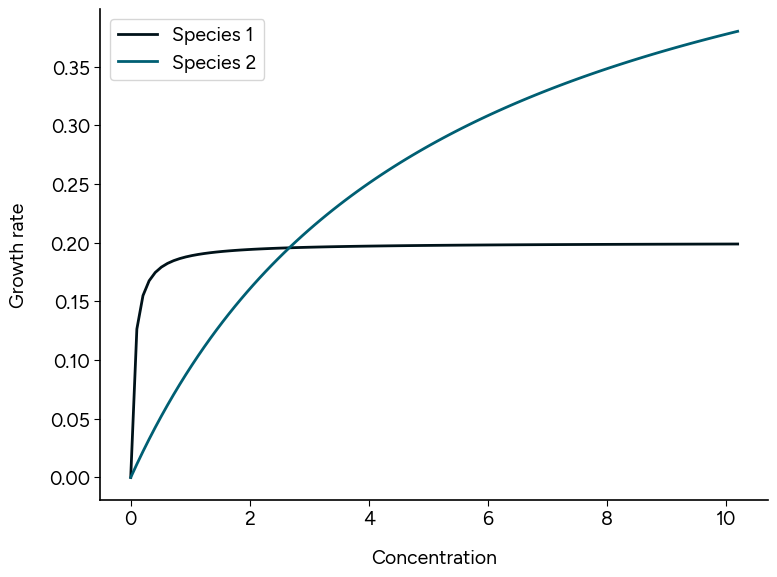

In [81]:
plotconc = np.linspace(0,np.max([K1,K2])*2,100)
plt.plot(plotconc,a1*plotconc/(K1+plotconc),label="Species 1")
plt.plot(plotconc,a2*plotconc/(K2+plotconc),label="Species 2")
plt.xlabel("Concentration")
plt.ylabel("Growth rate")
plt.legend()

In [35]:
supply_conc = 10
dilution_times = np.geomspace(2,72,20)[::-1]
chemostat_dilution = 0.1
dilution_fractions = np.exp(-chemostat_dilution*dilution_times)

In [36]:
survived_species = np.zeros(dilution_times.size)
warrays = np.zeros((dilution_times.size,2))
incount = 0

for j in range(dilution_times.size):
    d = dilution_fractions[j]
    tau = dilution_times[j]
    c0 = supply_conc
    sp1survival = species_survivability(K1,a1,d,tau,c0)
    sp2survival = species_survivability(K2,a2,d,tau,c0)

    if(sp1survival and sp2survival):
        incount+=1
        
        w2 = d * fn(K1,K2,a1,a2,1,1,c0*(1-d),d)
        w1 = d * fn(K2,K1,a2,a1,1,1,c0*(1-d),d)

        warrays[j,0] = w1
        warrays[j,1] = w2
        
        if(w1 >= 1 and w2 < 1):
            survived_species[j] = 1
        if(w2 >= 1 and w1 < 1):
            survived_species[j] = 2
        if(w1 >= 1 and w2 >= 1):
            survived_species[j] = 1.5

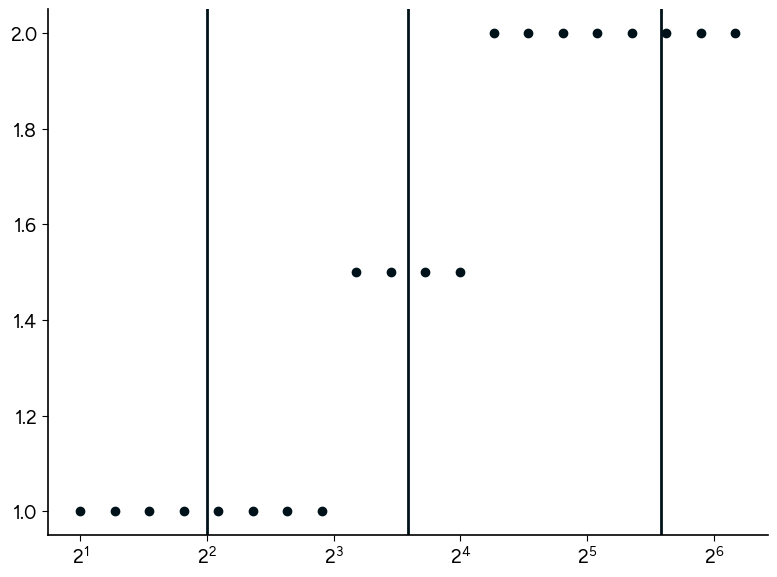

In [37]:
plt.plot(dilution_times,survived_species,"o")
plt.xscale('log',base=2)
plt.axvline(12)
plt.axvline(4)
plt.axvline(48)

### Simulation of dynamics for interactions

In [38]:
@njit
def serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2):
    n1 = y[0]
    n2 = y[1]
    cres = y[2]

    n1dot = n1*alpha1*cres/(km1+cres)
    n2dot = n2*alpha2*cres/(km2+cres)
    cresdot = - n1*alpha1*cres/(km1+cres)/yiel1 - n2*alpha2*cres/(km2+cres)/yiel2


    return np.array([n1dot,n2dot,cresdot])

@njit
def rk4_integrator_conserved(ycur,t,dt,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,next_dilution,time_dilutions,dilution_factor):
    y = ycur.copy()
    if(next_dilution<len(time_dilutions)):
        if(np.round(t,5)<time_dilutions[next_dilution] and np.round(t+dt,5) >= time_dilutions[next_dilution]):
            y[:2] = y[:2] * dilution_factor
            y[2:] = (1-dilution_factor)*s_vector + y[2] * dilution_factor                                    
            next_dilution += 1
        else:
            k1 = serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k2 = serial_dilutions(y+dt*k1/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k3 = serial_dilutions(y+dt*k2/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
            k4 = serial_dilutions(y+dt*k3,t+dt,alpha1,alpha2,km1,km2,yiel1,yiel2)
            y = y + dt*(k1+2*k2+2*k3+k4)/6.0
    else:
        k1 = serial_dilutions(y,t,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k2 = serial_dilutions(y+dt*k1/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k3 = serial_dilutions(y+dt*k2/2.0,t+dt/2.0,alpha1,alpha2,km1,km2,yiel1,yiel2)
        k4 = serial_dilutions(y+dt*k3,t+dt,alpha1,alpha2,km1,km2,yiel1,yiel2)
        y = y + dt*(k1+2*k2+2*k3+k4)/6.0
    return y,next_dilution

@njit
def dilution_integrate_conserved(y0,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,time_dilutions,dilution_factor,dt,t_integrate):
    y = np.zeros((len(t_integrate),len(y0)),dtype=np.float64)
    y[0] = y0

    next_dilution = 0
    for i in range(1,len(t_integrate)):
        ytemp,next_dilution = rk4_integrator_conserved(y[i-1],t_integrate[i-1],dt,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,next_dilution,time_dilutions,dilution_factor)
        y[i] = ytemp
    return y

In [39]:
def effIntFn(alpha_vec,K_vec,yield_vec,c,sp1id,sp2id):
    id1,id2 = sp1id-1,sp2id-1
    return - alpha_vec[id1] * K_vec[id1] / (K_vec[id1] + c)**2 * alpha_vec[id2] * c / (K_vec[id2] + c) / yield_vec[id2]

In [162]:
s_vector = supply_conc
y_init = np.array([y1/2,y2/2,s_vector])

alpha1,alpha2 = a1,a2
km1,km2 = K1,K2
yiel1,yiel2 = y1,y2

dt = 1e-5
t_integrate = np.arange(0,480,dt)

In [163]:
times_dilution_sim = np.array([0.001,1,12,48])
dils_frac_sim = np.zeros(times_dilution_sim.size)
simulation_data = []

for i in range(len(times_dilution_sim)):
    dils_frac_sim[i] = np.exp(-chemostat_dilution * times_dilution_sim[i])
    t_dilutions = np.arange(0,t_integrate[-1],times_dilution_sim[i])[1:]
    simulation_data.append(dilution_integrate_conserved(y_init,alpha1,alpha2,km1,km2,yiel1,yiel2,s_vector,t_dilutions,dils_frac_sim[i],dt,t_integrate))

In [164]:
interaction_array = np.zeros((times_dilution_sim.size,2,2,t_integrate.size))

for i in range(times_dilution_sim.size):
    conc_sim = simulation_data[i][:,2]
    for j in range(2):
        for k in range(2):
            interaction_array[i,j,k] = effIntFn(alpha_vec,K_vec,yield_vec,conc_sim,j+1,k+1)

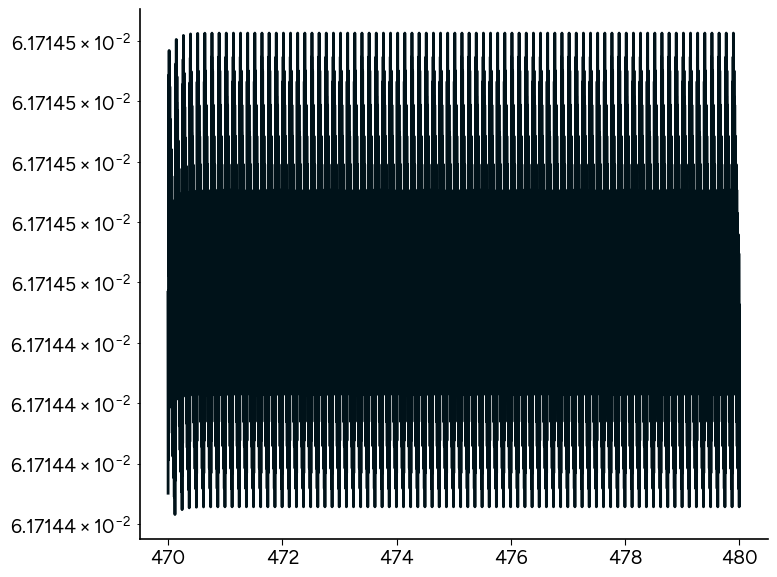

In [190]:
plt.plot(t_integrate[-int(10/dt)::100],simulation_data[0][:,2][-int(10 /dt)::100])

plt.yscale('log')

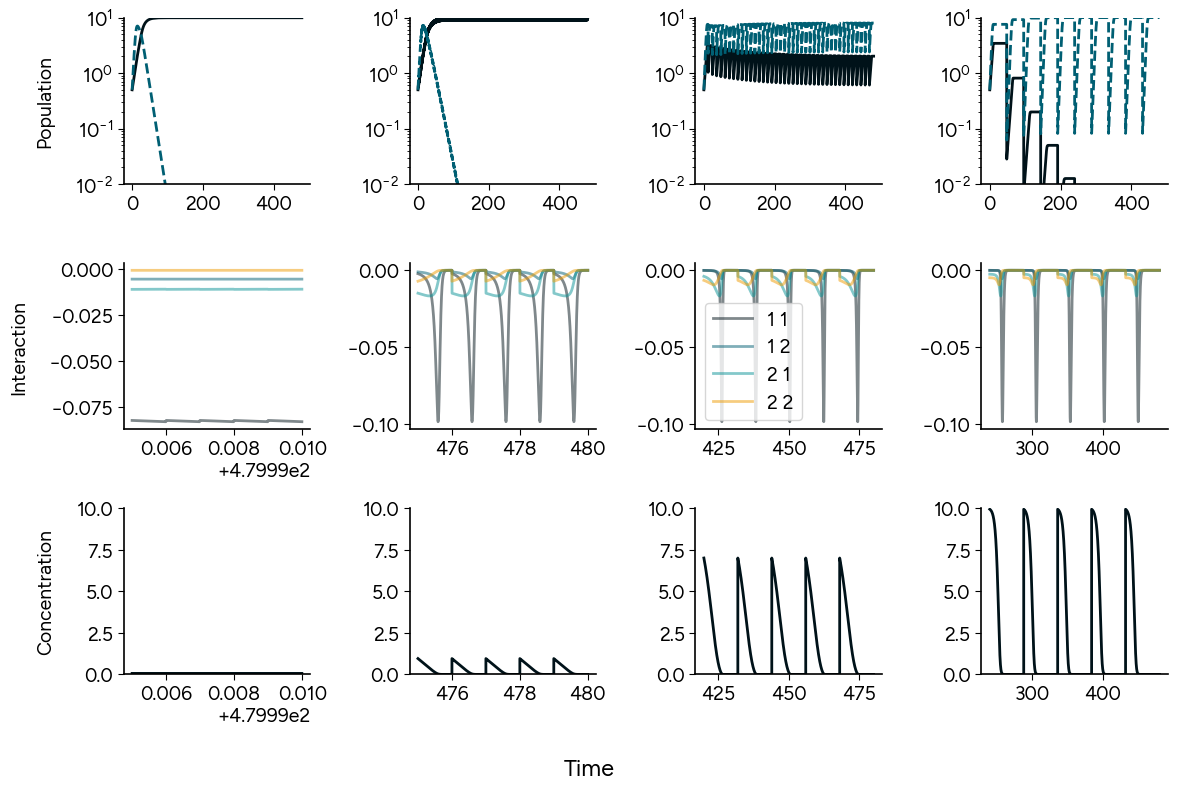

In [168]:
fig,ax = plt.subplots(3,len(times_dilution_sim),figsize=(12,8))

for i in range(times_dilution_sim.size):
    y_soln = simulation_data[i]
    ax[0,i].plot(t_integrate[::10000],y_soln[:,0][::10000])
    ax[0,i].plot(t_integrate[::10000],y_soln[:,1][::10000],ls="--")
    ax[0,i].set_yscale('log')

    cutoff = -int(5 * times_dilution_sim[i]/dt)
    conc_sim = simulation_data[i][:,2]
    
    for j in range(2):
        for k in range(2):
            if(i==2):
                ax[1,i].plot(t_integrate[cutoff:],-(np.abs(interaction_array[i,j,k,cutoff:]) ),alpha=0.5,label="%d %d"%(j+1,k+1))
                ax[1,i].legend()
            else:
                ax[1,i].plot(t_integrate[cutoff:],-(np.abs(interaction_array[i,j,k,cutoff:]) ),alpha=0.5)
    ax[2,i].plot(t_integrate[cutoff:],conc_sim[cutoff:])

    

    ax[0,i].set_yscale("log")
    ax[0,i].set_ylim(1e-2,1e1)
    # ax[1,i].set_yscale("log")
    # ax[1,i].set_xscale("log")
    # ax[1,i].set_xlim(-0.5,10)
    # ax[1,i].set_ylim(-8,)

    
    ax[2,i].set_ylim(0,10)

ax[0,0].set_ylabel("Population")
ax[1,0].set_ylabel("Interaction")
ax[2,0].set_ylabel("Concentration")
# ax[0,1].set_xlabel("Time")
# ax[1,1].set_xlabel("Time")
# ax[2,1].set_xlabel("Time")

fig.supxlabel("Time")
plt.show()


In [169]:
integrated_interaction = np.zeros((times_dilution_sim.size,2,2))
growth_matrix = np.zeros((times_dilution_sim.size,2))
intergated_growth = np.zeros((times_dilution_sim.size,2))

In [175]:
for i in range(times_dilution_sim.size):
    lastdil = -int(times_dilution_sim[i]/dt)
    conc_sim = simulation_data[i][:,2]
    for j in range(2):
        for k in range(2):
            integrated_interaction[i,j,k] = integrate.simps(interaction_array[i,j,k,lastdil:],t_integrate[lastdil:])
        growth_matrix[i,j] = alpha_vec[j] * conc_sim[lastdil] / (K_vec[j] + conc_sim[lastdil])
        intergated_growth[i,j] = -integrate.simps(alpha_vec[j] * conc_sim[lastdil:] / (K_vec[j] + conc_sim[lastdil:]),conc_sim[lastdil:])
    print(conc_sim[lastdil])

0.06172448930637004
0.951608851212587
6.98805788087798
9.9177025295098


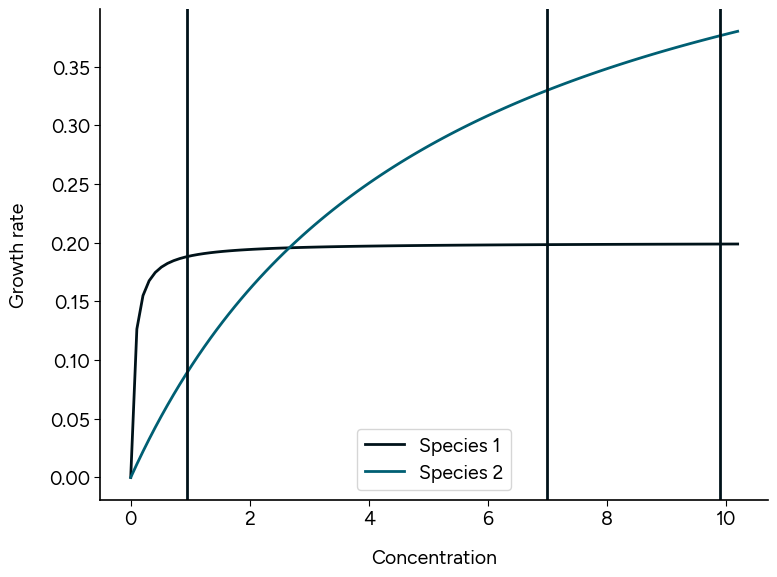

In [176]:
plotconc = np.linspace(0,np.max([K1,K2])*2,100)
plt.plot(plotconc,a1*plotconc/(K1+plotconc),label="Species 1")
plt.plot(plotconc,a2*plotconc/(K2+plotconc),label="Species 2")
plt.xlabel("Concentration")
plt.ylabel("Growth rate")
plt.legend()
plt.axvline(0.95)
plt.axvline(7)
plt.axvline(9.9)

In [177]:
for i in range(times_dilution_sim.size):
    tg = growth_matrix[i]
    ti = integrated_interaction[i]
    # print(tg)
    print((tg[0] - tg[1] * ti[0,1] / ti[1,1]),(tg[1] - tg[0] * ti[1,0] / ti[0,0]) ,(tg[0]*ti[0,0] - tg[1]*ti[1,1]))

0.05041559057631759 -0.006737725515366596 -8.276376407042654e-06
0.11983664313876394 -0.003131707722753563 -0.003365976913463661
0.14439643088523782 0.1621521568284709 0.00020845108445108687
0.11990469069305557 0.29754023819972697 -0.02282841688722672


In [178]:
integrated_interaction[0]

array([[-8.16567148e-05, -5.46613414e-06],
       [-1.09130226e-05, -7.30530031e-07]])

In [179]:
integrated_interaction[1]

array([[-0.01904836, -0.00185113],
       [-0.00939203, -0.00242925]])

In [180]:
integrated_interaction[2]

array([[-0.07362757, -0.00735125],
       [-0.0621415 , -0.04494065]])

In [181]:
growth_matrix

array([[0.10141672, 0.00681612],
       [0.18813771, 0.08963187],
       [0.1982974 , 0.32951472],
       [0.19879732, 0.37642845]])

In [183]:
interaction_array[0][:,:,-1]

array([[-0.08282601, -0.00552227],
       [-0.01098102, -0.00073214]])

In [196]:
K1/(alpha1/chemostat_dilution - 1)

0.06